# GTSRB Traffic Sign Classification
**Simple CNN + MobileNetV2 Transfer Learning**

This notebook trains two models:
1. Simple CNN (from scratch)
2. MobileNetV2 (transfer learning)

---

## Part 1: Setup & Data Loading

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports
import os
import pickle
import random
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.19.0


In [3]:
# Load Dataset
BASE_PATH = '/content/drive/MyDrive/TrafficSignProject/GTSRB'

def load_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return np.array(data['features']), np.array(data['labels'])

X_train, y_train = load_data(f'{BASE_PATH}/train.p')
X_valid, y_valid = load_data(f'{BASE_PATH}/valid.p')
X_test, y_test = load_data(f'{BASE_PATH}/test.p')

# Load class names
df_signs = pd.read_csv(f'{BASE_PATH}/signname.csv')
NUM_CLASSES = len(df_signs)
sign_names = dict(zip(df_signs.ClassId, df_signs.SignName))

print(f'Classes: {NUM_CLASSES}')
print(f'Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}')

Classes: 43
Train: (34799, 32, 32, 3), Valid: (4410, 32, 32, 3), Test: (12630, 32, 32, 3)


In [4]:
# Preprocessing - Normalize to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode labels
y_train_oh = to_categorical(y_train, NUM_CLASSES)
y_valid_oh = to_categorical(y_valid, NUM_CLASSES)
y_test_oh = to_categorical(y_test, NUM_CLASSES)

print(f'Data range: [{X_train.min():.1f}, {X_train.max():.1f}]')

Data range: [0.0, 1.0]


## Part 2: Data Visualization

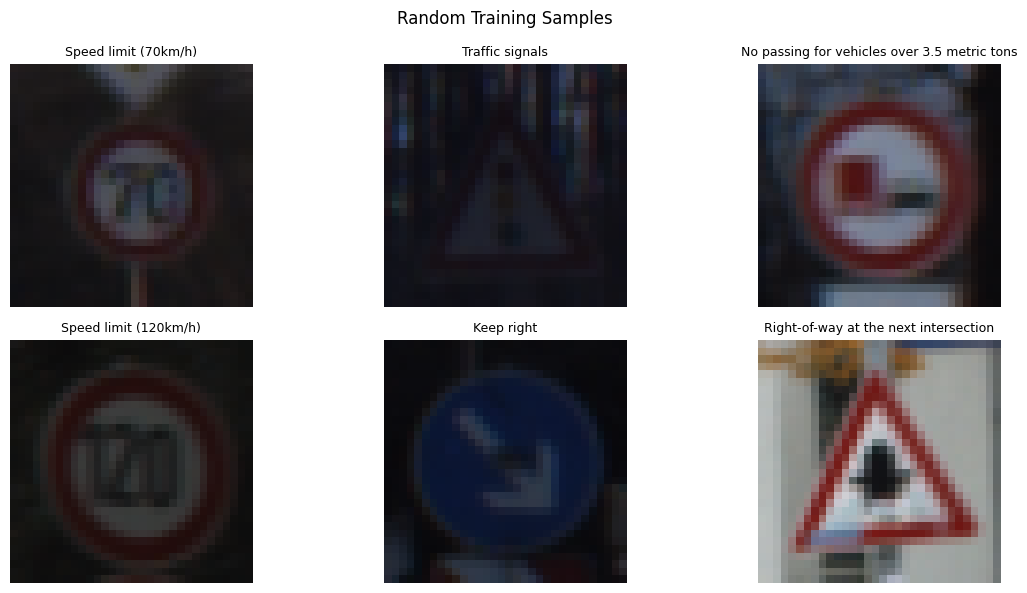

In [5]:
# Show random samples
plt.figure(figsize=(12, 6))
for i in range(6):
    idx = random.randint(0, len(X_train)-1)
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('Random Training Samples')
plt.tight_layout()
plt.show()

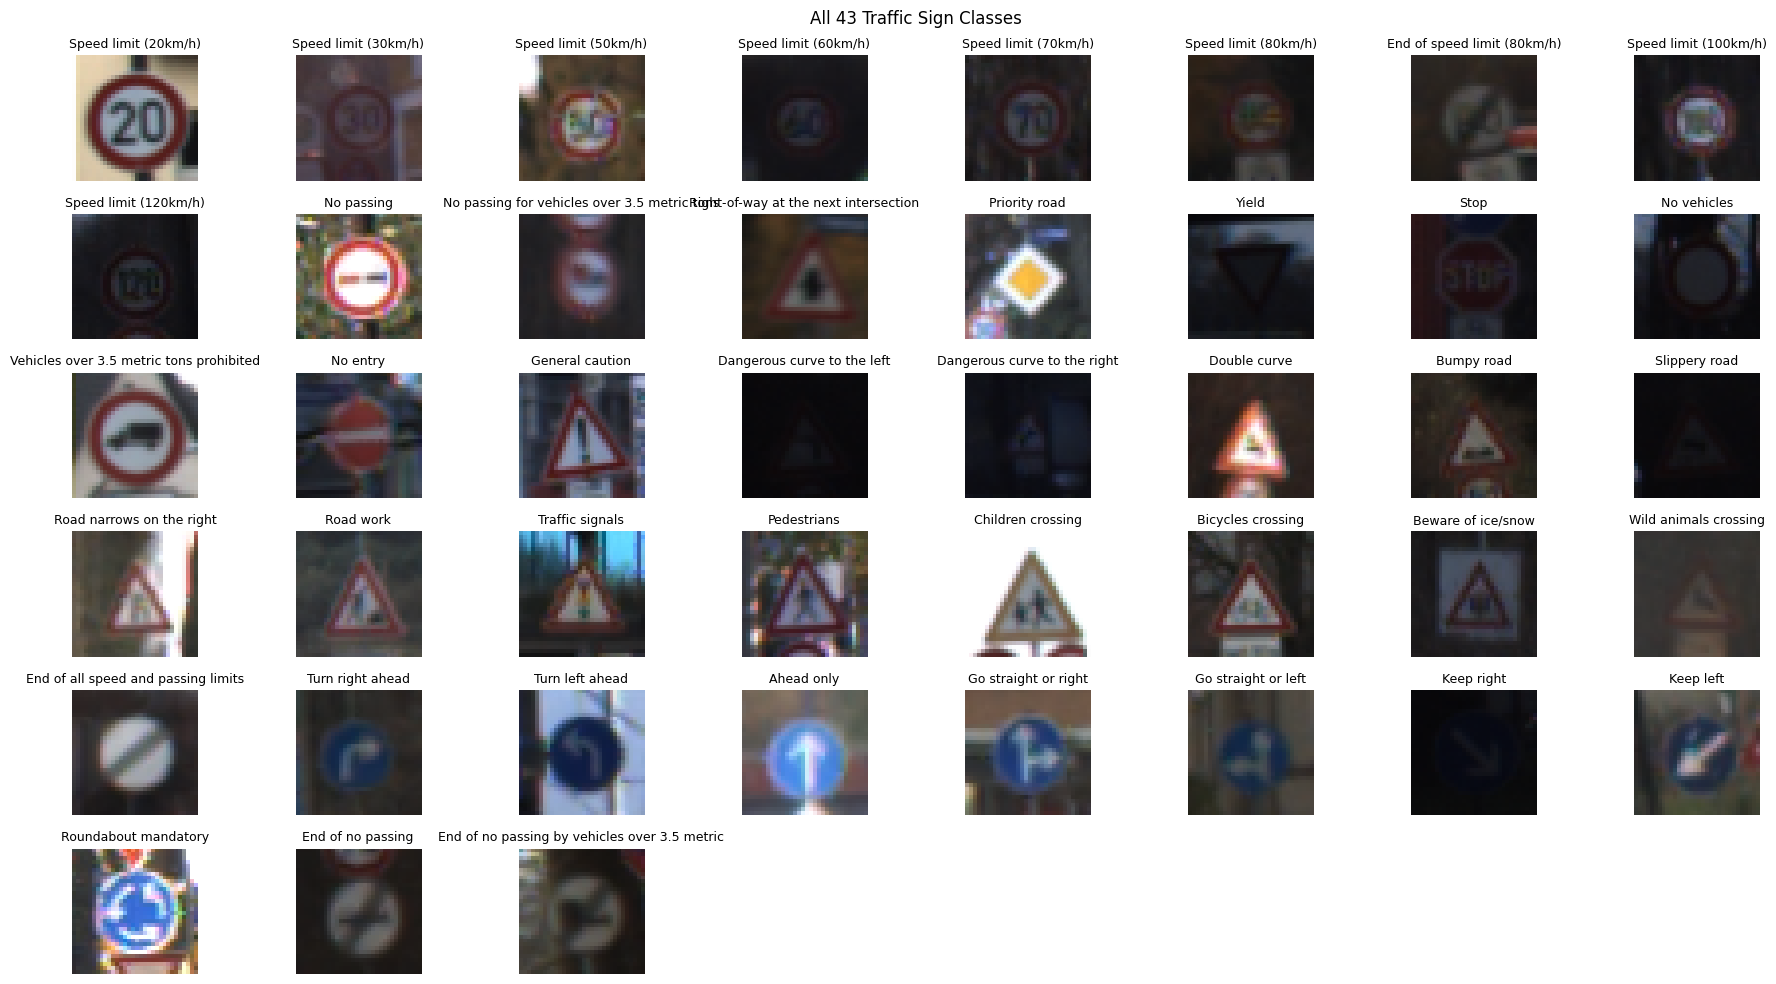

In [6]:
# Show one sample per class
examples = {}
for i, label in enumerate(y_train):
    if label not in examples:
        examples[label] = i
    if len(examples) == NUM_CLASSES:
        break

plt.figure(figsize=(18, 10))
for i, (label, idx) in enumerate(sorted(examples.items())):
    plt.subplot(6, 8, i+1)
    plt.imshow(X_train[idx])
    plt.title(sign_names[y_train[idx]], fontsize=9)
    plt.axis('off')
plt.suptitle('All 43 Traffic Sign Classes')
plt.tight_layout()
plt.show()

---
## Part 3: Model 1 - Simple CNN

In [7]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

BATCH_SIZE = 32
train_gen = train_datagen.flow(X_train, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
# Build Simple CNN
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

simple_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
simple_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,043 (1.05 MB)

 Trainable params: 276,043 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train Simple CNN
cnn_ckpt = '/content/drive/MyDrive/TrafficSignProject/simple_cnn_best.h5'

cnn_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(cnn_ckpt, monitor='val_accuracy', save_best_only=True)
]

history_cnn = simple_cnn.fit(
    train_gen,
    epochs=15,
    validation_data=valid_gen,
    callbacks=cnn_callbacks
)

# Evaluate
cnn_loss, cnn_acc = simple_cnn.evaluate(X_test, y_test_oh, verbose=0)
print(f'\nSimple CNN Test Accuracy: {cnn_acc*100:.2f}%')

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2328 - loss: 2.8293

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.2332 - loss: 2.8273 - val_accuracy: 0.7766 - val_loss: 0.8052
Epoch 2/15
1087/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6986 - loss: 0.9294

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.6987 - loss: 0.9291 - val_accuracy: 0.9218 - val_loss: 0.2599
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8538 - loss: 0.4530

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.8538 - loss: 0.4530 - val_accuracy: 0.9372 - val_loss: 0.2160
Epoch 4/15
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9088 - loss: 0.2957

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9088 - loss: 0.2956 - val_accuracy: 0.9683 - val_loss: 0.1151
Epoch 5/15
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9364 - loss: 0.2084

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9364 - loss: 0.2084 - val_accuracy: 0.9776 - val_loss: 0.1008
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9498 - loss: 0.1600 - val_accuracy: 0.9755 - val_loss: 0.0976
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9580 - loss: 0.1411 - val_accuracy: 0.9737 - val_loss: 0.0937
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9629 - loss: 0.1202

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9629 - loss: 0.1202 - val_accuracy: 0.9825 - val_loss: 0.0628
Epoch 9/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9664 - loss: 0.1059 - val_accuracy: 0.9780 - val_loss: 0.0733
Epoch 10/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9713 - loss: 0.0908 - val_accuracy: 0.9803 - val_loss: 0.1006
Epoch 11/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9739 - loss: 0.0917 - val_accuracy: 0.9789 - val_loss: 0.1514
Epoch 12/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.9741 - loss: 0.0869 - val_accuracy: 0.9791 - val_loss: 0.0936
Epoch 13/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.9795 - loss: 0.0719 - val_accuracy: 0.9814 - val_loss: 0.0624

Simple CNN Test Accuracy: 97.43%


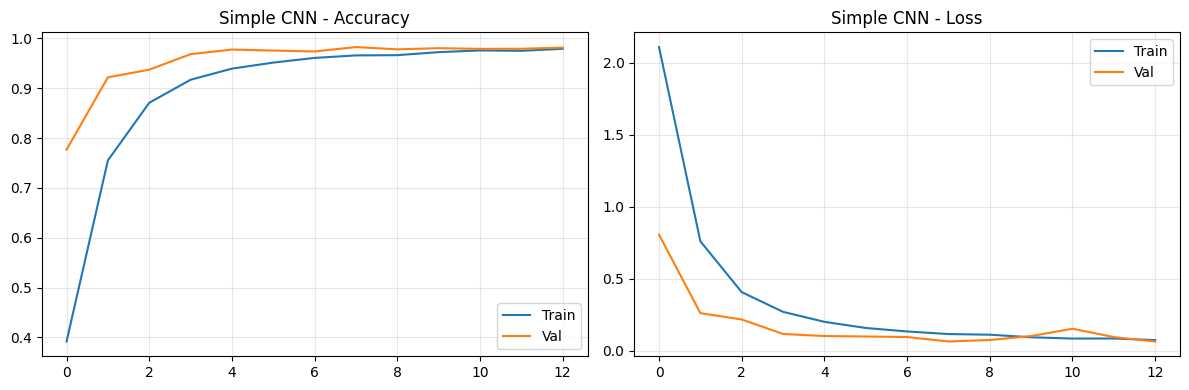

In [10]:
# Plot CNN Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_cnn.history['accuracy'], label='Train')
ax[0].plot(history_cnn.history['val_accuracy'], label='Val')
ax[0].set_title('Simple CNN - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_cnn.history['loss'], label='Train')
ax[1].plot(history_cnn.history['val_loss'], label='Val')
ax[1].set_title('Simple CNN - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

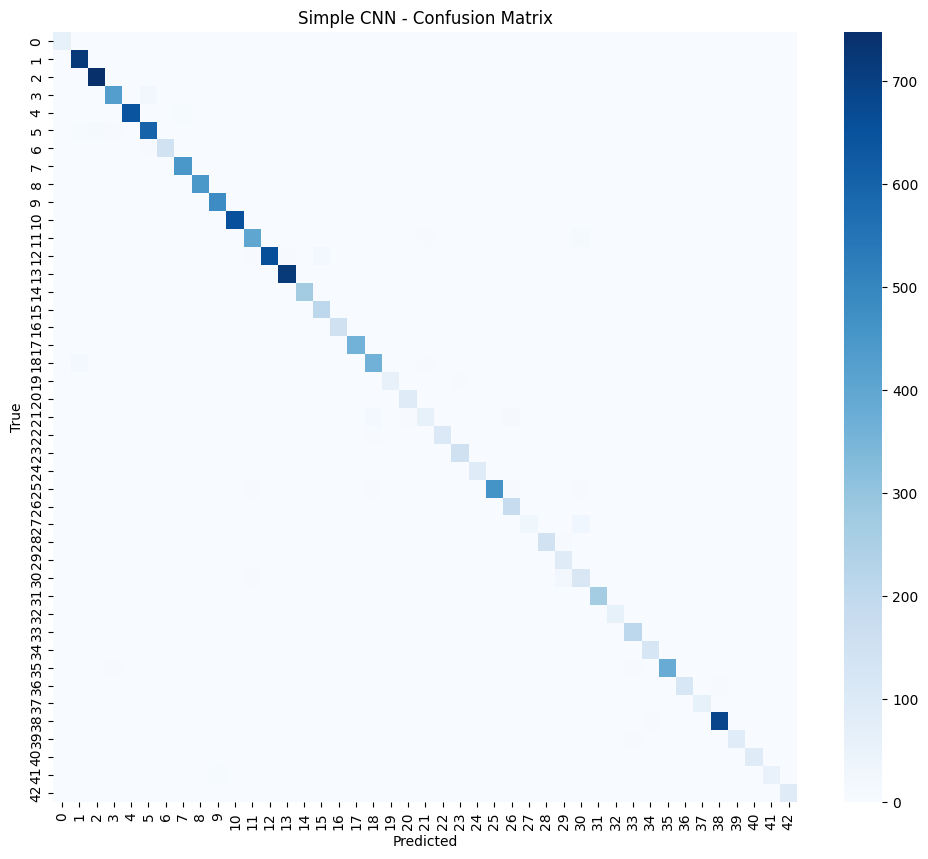

              precision    recall  f1-score   support

           0      0.967     0.983     0.975        60
           1      0.962     0.997     0.980       720
           2      0.980     0.997     0.989       750
           3      0.973     0.951     0.962       450
           4      0.992     0.980     0.986       660
           5      0.957     0.951     0.954       630
           6      0.993     0.973     0.983       150
           7      0.978     0.998     0.988       450
           8      0.991     0.998     0.994       450
           9      0.986     1.000     0.993       480
          10      1.000     0.994     0.997       660
          11      0.962     0.957     0.959       420
          12      1.000     0.955     0.977       690
          13      0.993     0.996     0.994       720
          14      1.000     1.000     1.000       270
          15      0.921     1.000     0.959       210
          16      1.000     1.000     1.000       150
          17      1.000    

In [11]:
# CNN Confusion Matrix
y_pred_cnn = np.argmax(simple_cnn.predict(X_test, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), cmap='Blues', annot=False)
plt.title('Simple CNN - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_cnn, digits=3))

---
## Part 4: Model 2 - MobileNetV2 (Transfer Learning)

In [15]:
IMG_SIZE = 96

# Instead of resizing already-normalized images, resize uint8 first
def resize_images_uint8(X_uint8, size):
    """Resize uint8 images, then normalize"""
    resized = np.zeros((len(X_uint8), size, size, 3), dtype=np.float32)
    for i in range(len(X_uint8)):
        resized[i] = cv2.resize(X_uint8[i], (size, size)).astype('float32') / 255.0
    return resized

# Load raw data again for MobileNet (before normalization)
X_train_raw, _ = load_data(f'{BASE_PATH}/train.p')
X_valid_raw, _ = load_data(f'{BASE_PATH}/valid.p')
X_test_raw, _ = load_data(f'{BASE_PATH}/test.p')

X_train_m = resize_images_uint8(X_train_raw, IMG_SIZE)
X_valid_m = resize_images_uint8(X_valid_raw, IMG_SIZE)
X_test_m = resize_images_uint8(X_test_raw, IMG_SIZE)

del X_train_raw, X_valid_raw, X_test_raw
gc.collect()

print(f'Resized: {X_train_m.shape}')


Resized: (34799, 96, 96, 3)


In [16]:
# Build MobileNetV2 Model
# Using Rescaling layer for better serialization (converts [0,1] to [-1,1])
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.35  # Smallest variant for faster training
)
base_model.trainable = False  # Freeze base initially

# Build model with Rescaling layer (no Lambda for better serialization)
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# Rescaling: converts [0,1] to [-1,1] (MobileNetV2 expected range)
x = layers.Rescaling(scale=2.0, offset=-1.0)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

mobile_model = models.Model(inputs, outputs)
mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_96             │ (None, 3, 3, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,195 (2.86 MB)

 Trainable params: 338,987 (1.29 MB)

 Non-trainable params: 410,208 (1.56 MB)

In [17]:
# Data generators for MobileNet
train_datagen_m = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08
)

train_gen_m = train_datagen_m.flow(X_train_m, y_train_oh, batch_size=BATCH_SIZE, shuffle=True)
valid_gen_m = ImageDataGenerator().flow(X_valid_m, y_valid_oh, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
# Train MobileNetV2 (frozen base) - INCREASED EPOCHS
mobile_ckpt = '/content/drive/MyDrive/TrafficSignProject/mobilenetv2_best.h5'

mobile_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True),
    ModelCheckpoint(mobile_ckpt, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

# INCREASED from 10 to 20 epochs
history_mobile = mobile_model.fit(
    train_gen_m,
    epochs=20,
    validation_data=valid_gen_m,
    callbacks=mobile_callbacks
)

# Evaluate after frozen training
mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
print(f'\nMobileNetV2 (Frozen) Test Accuracy: {mobile_acc*100:.2f}%')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4594 - loss: 1.8494

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - accuracy: 0.4595 - loss: 1.8490 - val_accuracy: 0.6025 - val_loss: 1.2455 - learning_rate: 0.0010
Epoch 2/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6912 - loss: 0.9125

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.6912 - loss: 0.9125 - val_accuracy: 0.6177 - val_loss: 1.1957 - learning_rate: 0.0010
Epoch 3/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7373 - loss: 0.7714

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 83ms/step - accuracy: 0.7373 - loss: 0.7713 - val_accuracy: 0.6222 - val_loss: 1.2388 - learning_rate: 0.0010
Epoch 4/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7595 - loss: 0.6921

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.7595 - loss: 0.6921 - val_accuracy: 0.6472 - val_loss: 1.2091 - learning_rate: 0.0010
Epoch 5/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.7785 - loss: 0.6396 - val_accuracy: 0.6349 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 6/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8039 - loss: 0.5503

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 92s 84ms/step - accuracy: 0.8039 - loss: 0.5503 - val_accuracy: 0.6601 - val_loss: 1.2341 - learning_rate: 5.0000e-04
Epoch 7/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8169 - loss: 0.5271 - val_accuracy: 0.6574 - val_loss: 1.2246 - learning_rate: 5.0000e-04
Epoch 8/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 89s 82ms/step - accuracy: 0.8281 - loss: 0.4930 - val_accuracy: 0.6481 - val_loss: 1.2977 - learning_rate: 5.0000e-04
Epoch 9/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8368 - loss: 0.4699

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8368 - loss: 0.4699 - val_accuracy: 0.6655 - val_loss: 1.2478 - learning_rate: 2.5000e-04
Epoch 10/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8466 - loss: 0.4416 - val_accuracy: 0.6649 - val_loss: 1.2365 - learning_rate: 2.5000e-04
Epoch 11/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.8426 - loss: 0.4580 - val_accuracy: 0.6587 - val_loss: 1.2661 - learning_rate: 2.5000e-04
Epoch 12/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8542 - loss: 0.4270

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 89s 82ms/step - accuracy: 0.8542 - loss: 0.4269 - val_accuracy: 0.6660 - val_loss: 1.2554 - learning_rate: 1.2500e-04
Epoch 13/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.8544 - loss: 0.4192 - val_accuracy: 0.6626 - val_loss: 1.2490 - learning_rate: 1.2500e-04
Epoch 14/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - accuracy: 0.8596 - loss: 0.4078 - val_accuracy: 0.6630 - val_loss: 1.2662 - learning_rate: 1.2500e-04
Epoch 15/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8567 - loss: 0.3996

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 82ms/step - accuracy: 0.8567 - loss: 0.3996 - val_accuracy: 0.6662 - val_loss: 1.2540 - learning_rate: 6.2500e-05
Epoch 16/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.8620 - loss: 0.3969 - val_accuracy: 0.6655 - val_loss: 1.2509 - learning_rate: 6.2500e-05
Epoch 17/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8681 - loss: 0.3865

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.8681 - loss: 0.3865 - val_accuracy: 0.6703 - val_loss: 1.2622 - learning_rate: 6.2500e-05
Epoch 18/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 87s 80ms/step - accuracy: 0.8671 - loss: 0.3809 - val_accuracy: 0.6673 - val_loss: 1.2635 - learning_rate: 3.1250e-05
Epoch 19/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 88s 81ms/step - accuracy: 0.8669 - loss: 0.3824 - val_accuracy: 0.6694 - val_loss: 1.2576 - learning_rate: 3.1250e-05
Epoch 20/20
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 86s 79ms/step - accuracy: 0.8683 - loss: 0.3802 - val_accuracy: 0.6683 - val_loss: 1.2676 - learning_rate: 3.1250e-05

MobileNetV2 (Frozen) Test Accuracy: 70.82%


In [19]:
# Fine-tune MobileNetV2 - IMPROVED SETTINGS
print('Fine-tuning last 50 layers...')

# Unfreeze more layers (50 instead of 30)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Lower learning rate for fine-tuning (1e-5 instead of 1e-4)
mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune callbacks
ft_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(mobile_ckpt, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# INCREASED from 8 to 15 epochs
history_ft = mobile_model.fit(
    train_gen_m,
    epochs=15,
    validation_data=valid_gen_m,
    callbacks=ft_callbacks
)

mobile_loss, mobile_acc = mobile_model.evaluate(X_test_m, y_test_oh, verbose=0)
print(f'\nFine-tuned MobileNetV2 Test Accuracy: {mobile_acc*100:.2f}%')

Fine-tuning last 50 layers...
Epoch 1/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4989 - loss: 3.6172

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 129s 100ms/step - accuracy: 0.4990 - loss: 3.6163 - val_accuracy: 0.6435 - val_loss: 1.4750 - learning_rate: 1.0000e-05
Epoch 2/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6415 - loss: 1.5283

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 83ms/step - accuracy: 0.6416 - loss: 1.5282 - val_accuracy: 0.6506 - val_loss: 1.4580 - learning_rate: 1.0000e-05
Epoch 3/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7082 - loss: 1.0811

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 92s 85ms/step - accuracy: 0.7082 - loss: 1.0810 - val_accuracy: 0.6705 - val_loss: 1.3735 - learning_rate: 1.0000e-05
Epoch 4/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7411 - loss: 0.8755

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 141s 84ms/step - accuracy: 0.7411 - loss: 0.8755 - val_accuracy: 0.6746 - val_loss: 1.3023 - learning_rate: 1.0000e-05
Epoch 5/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7783 - loss: 0.7251

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 84ms/step - accuracy: 0.7783 - loss: 0.7251 - val_accuracy: 0.6866 - val_loss: 1.2244 - learning_rate: 1.0000e-05
Epoch 6/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7958 - loss: 0.6416

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.7958 - loss: 0.6416 - val_accuracy: 0.7027 - val_loss: 1.1518 - learning_rate: 1.0000e-05
Epoch 7/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8127 - loss: 0.5695

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 84ms/step - accuracy: 0.8127 - loss: 0.5695 - val_accuracy: 0.7197 - val_loss: 1.1043 - learning_rate: 1.0000e-05
Epoch 8/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8253 - loss: 0.5244

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8253 - loss: 0.5244 - val_accuracy: 0.7311 - val_loss: 1.0665 - learning_rate: 1.0000e-05
Epoch 9/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8416 - loss: 0.4707

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 83ms/step - accuracy: 0.8416 - loss: 0.4707 - val_accuracy: 0.7433 - val_loss: 1.0217 - learning_rate: 1.0000e-05
Epoch 10/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8496 - loss: 0.4356

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 91s 84ms/step - accuracy: 0.8496 - loss: 0.4356 - val_accuracy: 0.7528 - val_loss: 0.9979 - learning_rate: 1.0000e-05
Epoch 11/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 89s 82ms/step - accuracy: 0.8630 - loss: 0.4115 - val_accuracy: 0.7522 - val_loss: 0.9875 - learning_rate: 1.0000e-05
Epoch 12/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8689 - loss: 0.3884

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8689 - loss: 0.3884 - val_accuracy: 0.7556 - val_loss: 0.9795 - learning_rate: 1.0000e-05
Epoch 13/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8741 - loss: 0.3687

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 93s 85ms/step - accuracy: 0.8741 - loss: 0.3687 - val_accuracy: 0.7626 - val_loss: 0.9610 - learning_rate: 1.0000e-05
Epoch 14/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8791 - loss: 0.3574

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 139s 83ms/step - accuracy: 0.8791 - loss: 0.3574 - val_accuracy: 0.7687 - val_loss: 0.9302 - learning_rate: 1.0000e-05
Epoch 15/15
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8909 - loss: 0.3215

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 90s 83ms/step - accuracy: 0.8909 - loss: 0.3215 - val_accuracy: 0.7717 - val_loss: 0.9211 - learning_rate: 1.0000e-05

Fine-tuned MobileNetV2 Test Accuracy: 79.72%


In [ ]:
# Plot MobileNet Training
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history_mobile.history['accuracy'], label='Train')
ax[0].plot(history_mobile.history['val_accuracy'], label='Val')
ax[0].set_title('MobileNetV2 - Accuracy')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot(history_mobile.history['loss'], label='Train')
ax[1].plot(history_mobile.history['val_loss'], label='Val')
ax[1].set_title('MobileNetV2 - Loss')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

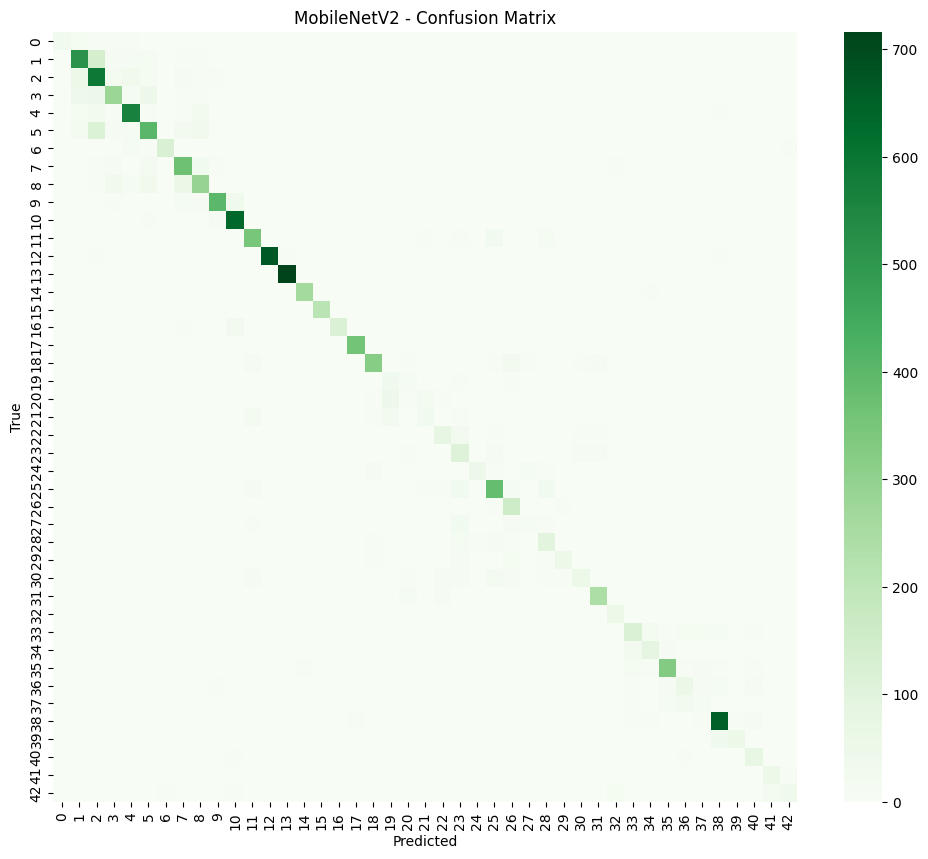

              precision    recall  f1-score   support

           0      0.933     0.467     0.622        60
           1      0.765     0.718     0.741       720
           2      0.627     0.785     0.697       750
           3      0.718     0.622     0.667       450
           4      0.822     0.856     0.839       660
           5      0.711     0.640     0.673       630
           6      0.939     0.827     0.879       150
           7      0.728     0.816     0.769       450
           8      0.690     0.642     0.665       450
           9      0.920     0.835     0.876       480
          10      0.882     0.964     0.921       660
          11      0.850     0.833     0.841       420
          12      0.996     0.971     0.983       690
          13      0.988     0.994     0.991       720
          14      0.985     0.974     0.980       270
          15      0.995     0.990     0.993       210
          16      0.984     0.807     0.886       150
          17      0.975    

In [21]:
# MobileNet Confusion Matrix
y_pred_mobile = np.argmax(mobile_model.predict(X_test_m, verbose=0), axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_mobile), cmap='Greens', annot=False)
plt.title('MobileNetV2 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_test, y_pred_mobile, digits=3))

---
## Part 5: Model Comparison

MODEL COMPARISON
Simple CNN:   97.43% accuracy
MobileNetV2:  79.72% accuracy

Parameters:
Simple CNN:   276,043
MobileNetV2:  749,195


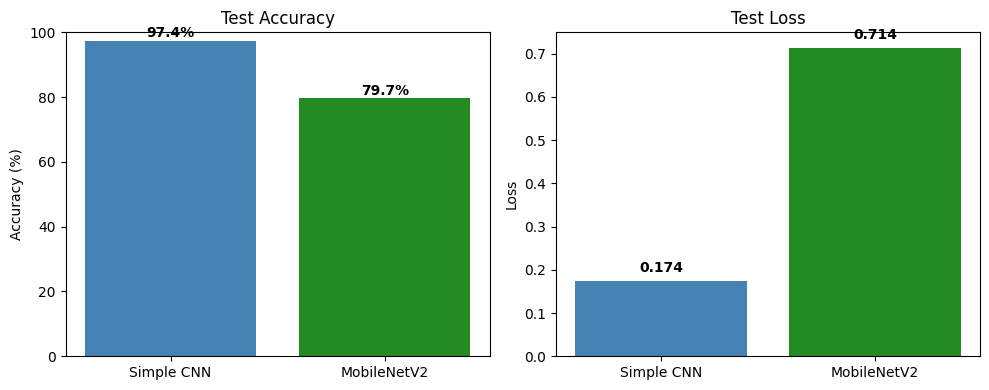


Best Model: Simple CNN


In [22]:
# Compare Models
print('='*50)
print('MODEL COMPARISON')
print('='*50)
print(f'Simple CNN:   {cnn_acc*100:.2f}% accuracy')
print(f'MobileNetV2:  {mobile_acc*100:.2f}% accuracy')
print(f'\nParameters:')
print(f'Simple CNN:   {simple_cnn.count_params():,}')
print(f'MobileNetV2:  {mobile_model.count_params():,}')

# Bar chart comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
names = ['Simple CNN', 'MobileNetV2']
colors = ['steelblue', 'forestgreen']

# Accuracy
accs = [cnn_acc*100, mobile_acc*100]
bars1 = ax[0].bar(names, accs, color=colors)
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Test Accuracy')
ax[0].set_ylim(0, 100)
for b, a in zip(bars1, accs):
    ax[0].text(b.get_x()+b.get_width()/2, b.get_height()+1, f'{a:.1f}%', ha='center', fontweight='bold')

# Loss
losses = [cnn_loss, mobile_loss]
bars2 = ax[1].bar(names, losses, color=colors)
ax[1].set_ylabel('Loss')
ax[1].set_title('Test Loss')
for b, l in zip(bars2, losses):
    ax[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.02, f'{l:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

best = 'Simple CNN' if cnn_acc > mobile_acc else 'MobileNetV2'
print(f'\nBest Model: {best}')

---
## Part 6: Test with Custom Image

Upload a traffic sign image:


Saving Screenshot 2025-12-17 014859.png to Screenshot 2025-12-17 014859.png


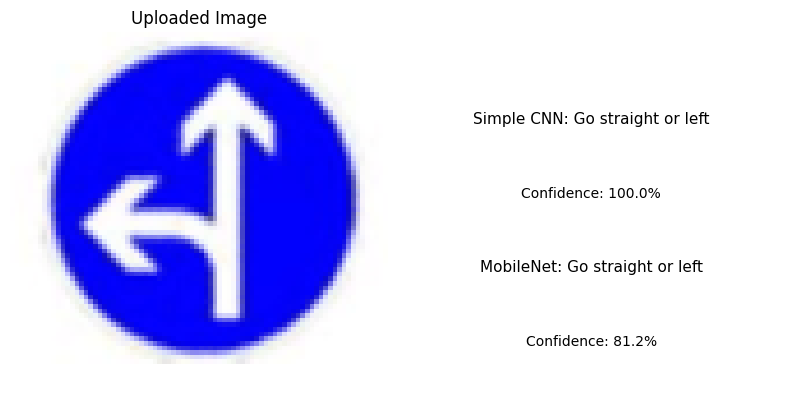

In [23]:
# Upload and predict custom image
from google.colab import files

print('Upload a traffic sign image:')
uploaded = files.upload()

for filename in uploaded.keys():
    img = Image.open(filename).convert('RGB')

    # Simple CNN prediction (32x32)
    img_cnn = np.array(img.resize((32, 32))).astype('float32') / 255.0
    pred_cnn = simple_cnn.predict(img_cnn.reshape(1, 32, 32, 3), verbose=0)
    cls_cnn = np.argmax(pred_cnn)

    # MobileNet prediction (96x96)
    img_mob = np.array(img.resize((IMG_SIZE, IMG_SIZE))).astype('float32') / 255.0
    pred_mob = mobile_model.predict(img_mob.reshape(1, IMG_SIZE, IMG_SIZE, 3), verbose=0)
    cls_mob = np.argmax(pred_mob)

    # Display
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.7, f'Simple CNN: {sign_names[cls_cnn]}', ha='center', fontsize=11)
    plt.text(0.5, 0.5, f'Confidence: {pred_cnn[0][cls_cnn]*100:.1f}%', ha='center', fontsize=10)
    plt.text(0.5, 0.3, f'MobileNet: {sign_names[cls_mob]}', ha='center', fontsize=11)
    plt.text(0.5, 0.1, f'Confidence: {pred_mob[0][cls_mob]*100:.1f}%', ha='center', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

---
## Part 7: Save Models

In [24]:
# Save final models
simple_cnn.save('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
mobile_model.save('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')

print('Models saved!')
print('- simple_cnn_final.h5')
print('- mobilenetv2_final.h5')

Models saved!
- simple_cnn_final.h5
- mobilenetv2_final.h5


In [25]:
# Final Summary
print('='*50)
print('PROJECT COMPLETE')
print('='*50)
print(f'''
Dataset: GTSRB ({NUM_CLASSES} classes)
Train: {len(X_train)} | Valid: {len(X_valid)} | Test: {len(X_test)}

Simple CNN:   {cnn_acc*100:.2f}% (32x32 input)
MobileNetV2:  {mobile_acc*100:.2f}% (96x96 input)

Best: {best}
''')

PROJECT COMPLETE

Dataset: GTSRB (43 classes)
Train: 34799 | Valid: 4410 | Test: 12630

Simple CNN:   97.43% (32x32 input)
MobileNetV2:  79.72% (96x96 input)

Best: Simple CNN



In [26]:
# Cleanup
del X_train_m, X_valid_m
gc.collect()
print('Memory cleaned up')

Memory cleaned up


## Download Model



In [27]:
# Add this cell at the end of your notebook
from google.colab import files
files.download('/content/drive/MyDrive/TrafficSignProject/simple_cnn_final.h5')
files.download('/content/drive/MyDrive/TrafficSignProject/mobilenetv2_final.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>